In [ ]:
!pip install scanpy
!pip install igraph
!pip install pydeseq2
!pip install adjustText
!pip install leidenalg
!pip install pyDESeq2
!pip install gseapy

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 787.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.9/232.9 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 96.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 5.7 MB/s eta 0:00:00
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8023 sha256=14d7dcb0c281662335844ace2578fa04b74c56a719dc84e747c21f82c15d9884
  Stored in directory: /root/.cache/pip/wheels/6a/aa/b9/eb5d4031476ec10802795b97ccf937b9bd998d68a9b268765a
Successfully built session-info
   ━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount("/content/drive")
from pathlib import Path
DATA = Path("/content/drive/My Drive/4060_final_project/GSE166181")

Mounted at /content/drive


# sc-RNA sequencing

In [ ]:
meta_data = pd.read_csv(DATA/"GSE166181_Metadata.tsv", sep="\t", index_col=0)
expression_matrix = pd.read_csv(DATA/"GSE166181_Normalized_UMI_CountMatrix.tsv", sep="\t", index_col=0).transpose()

print("Expression Matrix Shape:", expression_matrix.shape)
print("Meta Data Shape:", meta_data.shape)

adata = sc.AnnData(expression_matrix)
adata.obs = meta_data
print("AnnData Object Created:", adata)

Expression Matrix Shape: (51701, 17745)
Meta Data Shape: (51701, 13)
AnnData Object Created: AnnData object with n_obs × n_vars = 51701 × 17745
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'GeneReadCount', 'rRNAReads', 'pct.mito', 'pct.rRNA', 'pct.sncRNA', 'time', 'replicate', 'subject', 'response', 'sample'


Number of highly variable genes: 3461
Highly variable genes: ['LOC729737', 'NOC2L', 'ISG15', 'TNFRSF4', 'SDF4', 'C1orf233', 'NADK', 'PRKCZ', 'PLCH2', 'TPRG1L']


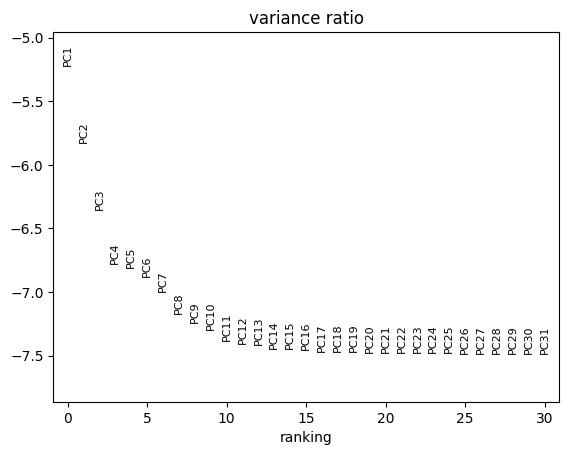

In [ ]:
# the data set is already normalized
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var.highly_variable]
highly_variable_genes = adata.var[adata.var['highly_variable']].index.tolist()

print(f"Number of highly variable genes: {len(highly_variable_genes)}")
print("Highly variable genes:", highly_variable_genes[:10])
adata = adata[:, adata.var.highly_variable].copy()

#PCA
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver="arpack")
sc.pl.pca_variance_ratio(adata, log=True)

In [ ]:
!pip install igraph
!pip install leidenalg

## UMAP plot depicting CD8+ T-cell heterogeneity
we got 8 clusters as the paper did.
Then we print out top 10 genes in each clusters.

For cluster 6, we can observe that it has similar high level expression genes as the paper mentioned.

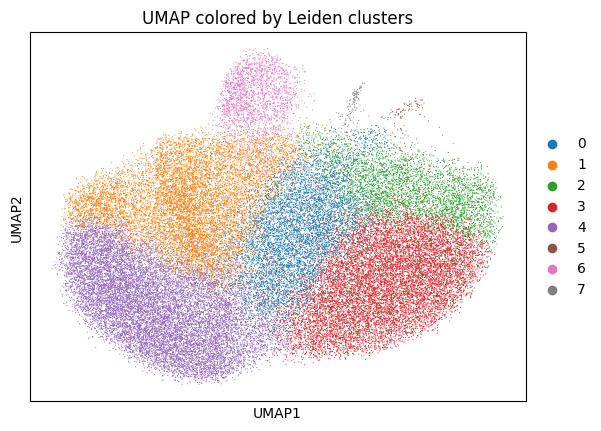

In [ ]:
# UMAP
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)  # adjust n_neighbors and n_pcs
sc.tl.leiden(adata, resolution=0.8, flavor="igraph", n_iterations=2, directed=False)
sc.tl.umap(adata)
sc.pl.umap(adata, color='leiden', title='UMAP colored by Leiden clusters')

In [ ]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')

clusters = adata.obs['leiden'].unique().tolist()
print("All clusters:", clusters)

for cluster in clusters:
    print(f"Top genes for cluster {cluster}:")
    print(adata.uns['rank_genes_groups']['names'][cluster][:10])
    print()

All clusters: ['0', '2', '1', '5', '6', '3', '4', '7']
Top genes for cluster 0:
['GZMK' 'CD74' 'DUSP2' 'PIK3R1' 'GZMA' 'CXCR4' 'ARL4C' 'RGS1' 'HLA.DRB1'
 'CMC1']

Top genes for cluster 2:
['NKG7' 'GZMH' 'GZMA' 'FGFBP2' 'GZMB' 'SH3BGRL3' 'PRF1' 'ARL4C' 'ITGB2'
 'ADGRG1']

Top genes for cluster 1:
['LTB' 'IL7R' 'FOS' 'JUNB' 'TNFAIP3' 'VIM' 'EEF1A1' 'JUN' 'RPL10' 'PABPC1']

Top genes for cluster 5:
['TUBA1B' 'HMGB2' 'PCNA' 'ACTG1' 'CD74' 'COTL1' 'CRIP1' 'DUT' 'HLA.DRA'
 'H2AFZ']

Top genes for cluster 6:
['KLRB1' 'IL7R' 'SLC4A10' 'ARL4C' 'LTB' 'DUSP1' 'PHACTR2' 'S100A4' 'GZMK'
 'CXCR4']

Top genes for cluster 3:
['NKG7' 'GZMH' 'FGFBP2' 'GZMB' 'S100A4' 'SH3BGRL3' 'ADGRG1' 'PRF1' 'GZMA'
 'ITGB2']

Top genes for cluster 4:
['LTB' 'LEF1' 'SELL' 'RPL10' 'NOSIP' 'PABPC1' 'IL7R' 'EEF1A1' 'XIST' 'MYC']

Top genes for cluster 7:
['DUSP2' 'MGEA5' 'CCNL1' 'CLDND1' 'CLK1' 'CD69' 'RSRP1' 'OGT' 'CXCR4'
 'MYBL1']



/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:455: 

The paper it mentioned mucosal-associated invariant T (MAIT) cells with homing properties were identified they expressed high level of **KLRB1, SLC4A10,** MAF, and **CXCR4**. Now we can allocate **Cluster 6 as MAIT**

Top genes for cluster 6:['**KLRB1**' 'IL7R' '**SLC4A10**' 'ARL4C' 'LTB' 'DUSP1' 'PHACTR2' 'S100A4' 'GZMK'
 '**CXCR4**']

/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:455: 

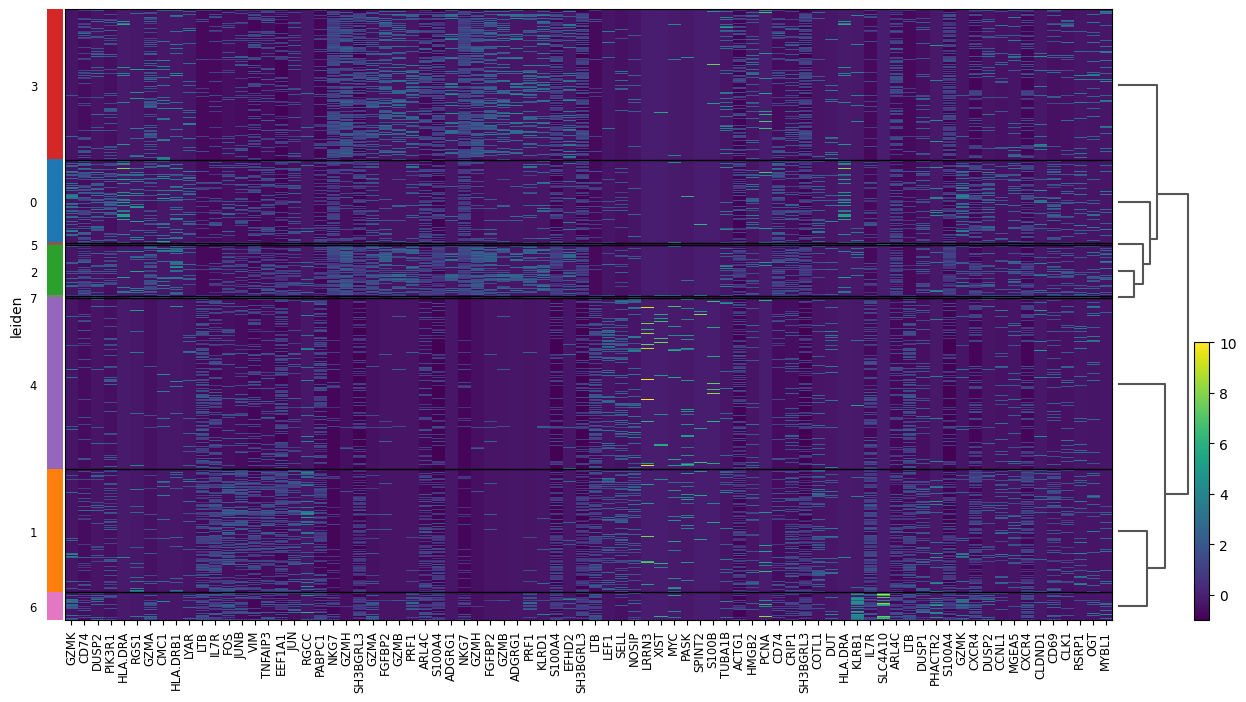

In [ ]:
sc.tl.rank_genes_groups(adata, groupby='leiden', method='t-test', n_genes=adata.shape[1])

markers = pd.DataFrame(adata.uns['rank_genes_groups']['names'])
top10_genes = []
for cluster in markers.columns:
    top10_genes.extend(markers[cluster][:10])  #fet top 10

sc.pl.heatmap(
    adata,
    var_names=top10_genes,
    groupby="leiden",
    cmap="viridis",
    show_gene_labels=True,
    figsize=(15, 8),
    dendrogram=True,
)
plt.show()


From the above we can see a highlight in cluster 6 on KLRB1 and SLC4A10. Now we can allocate cluster 6 as MAIT cells, then we will do futher explore only on MAIT cells.

In [ ]:
# Create a mapping for the clusters
cluster_names = {
    '6': 'MAIT'
}
# Map the cluster names to a new column 'cell_type' in the .obs attribute
adata.obs['cell_type'] = adata.obs['leiden'].map(cluster_names)
#  cell_type= 'MAIT'
mait_adata = adata[adata.obs['cell_type'] == 'MAIT'].copy()
# print(mait_adata)

# print(mait_adata.obs['cell_type'].value_counts())

from paper we can get: Our approach identified two different types of MAIT cells with differential expression of genes related to
T-cell activation or effector functions DUSP1, ZFP36, TNFAIP3, ZFP36L2, FOS, CXCR4, NFKBIA, CD69, TSC22D3, BHLHE40 and JUN.

Follow their conclusion, we defined activation gene mark to identify the activate status of MAIT cells.

*in our outcome we delete ZFP36L2 as it could not be found in cluster 6

## UMAP plot of MAIT cells. Not activated MAIT are in orange and activated ones are in blue.

                                     activation_score activation_status
cell_ID                                                                
R T0-Mela10 rep2_gcgaatgatcaagaaggg          1.599563         activated
R T0-Mela10 rep2_cgaaagggtgctcttgaa          0.887644         activated
R T0-Mela10 rep2_tcatcaatccggcagact          1.083782         activated
R T0-Mela10 rep2_accttcgtcggcgactcg          1.034560         activated
R T0-Mela10 rep2_agcacggccagaactgca          1.433229         activated


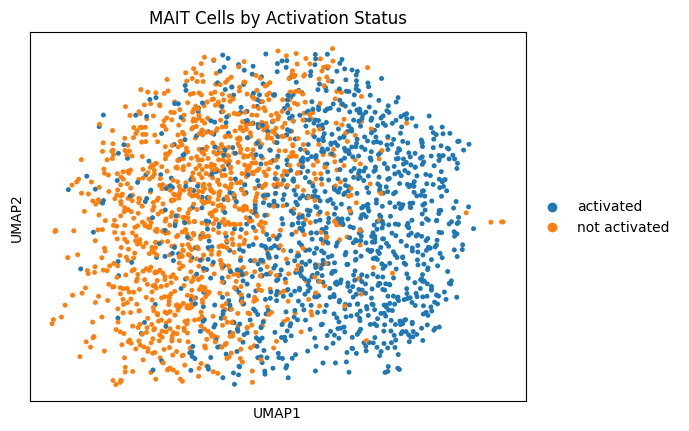

In [ ]:
activation_marker_genes = ['DUSP1', 'ZFP36', 'TNFAIP3', 'FOS', 'CXCR4', 'NFKBIA', 'CD69', 'TSC22D3', 'BHLHE40', 'JUN']

activation_mait = mait_adata[:, activation_marker_genes].X
activation_score = activation_mait.mean(axis=1)

mait_adata.obs['activation_score'] = activation_score
# set threshold to seperate whether activated
threshold = mait_adata.obs['activation_score'].median()
mait_adata.obs['activation_status'] = ['activated' if score > threshold else 'not activated ' for score in mait_adata.obs['activation_score']]

print(mait_adata.obs[['activation_score', 'activation_status']].head())
# UMAP
sc.tl.umap(mait_adata)
sc.pl.umap(mait_adata, color='activation_status', title="MAIT Cells by Activation Status")


Following heatmap shows the expression of mark genes in two group.

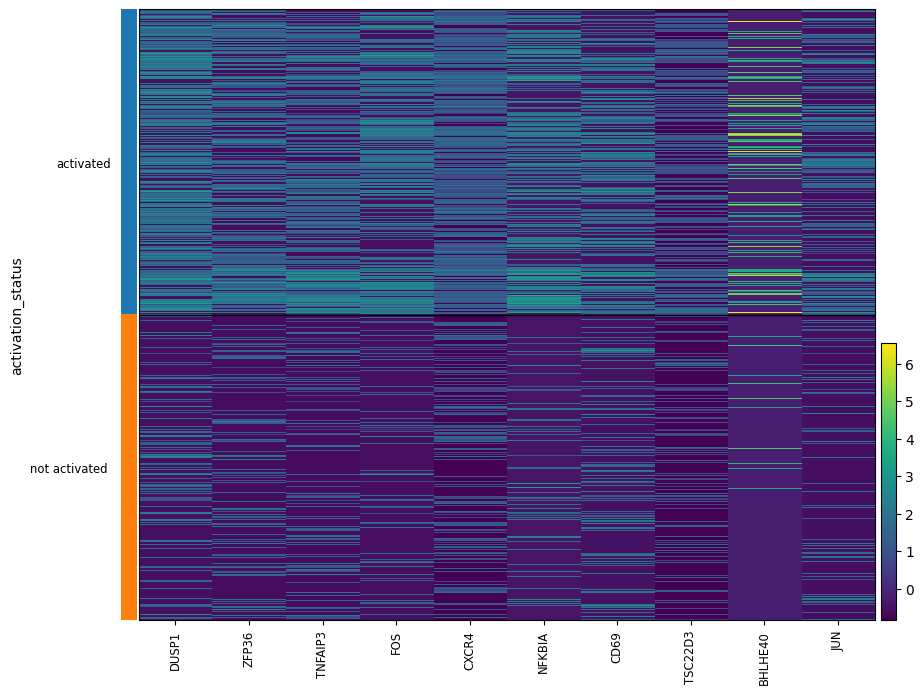

In [ ]:
activated_cells = mait_adata[mait_adata.obs['activation_status'] == 'activated']
no_activated_cells = mait_adata[mait_adata.obs['activation_status'] == 'not activated']

activated_data = activated_cells[:, activation_marker_genes].X
no_activated_cells = no_activated_cells[:, activation_marker_genes].X

import pandas as pd
activated_df = pd.DataFrame(activated_data, columns=activation_marker_genes)
no_activated_df = pd.DataFrame(no_activated_cells, columns=activation_marker_genes)


activated_df['activation_status'] = 'activated'
no_activated_df['activation_status'] = 'no_activated'


heatmap_data = pd.concat([activated_df, no_activated_df])
sc.pl.heatmap(
    mait_adata,
    var_names=activation_marker_genes,
    groupby='activation_status',
    cmap='viridis',
    show_gene_labels=True,
    figsize=(10, 8),
)
plt.show()


## UMAP plot representing two clusters of MAIT cells between R and NR at T0, T1, T2

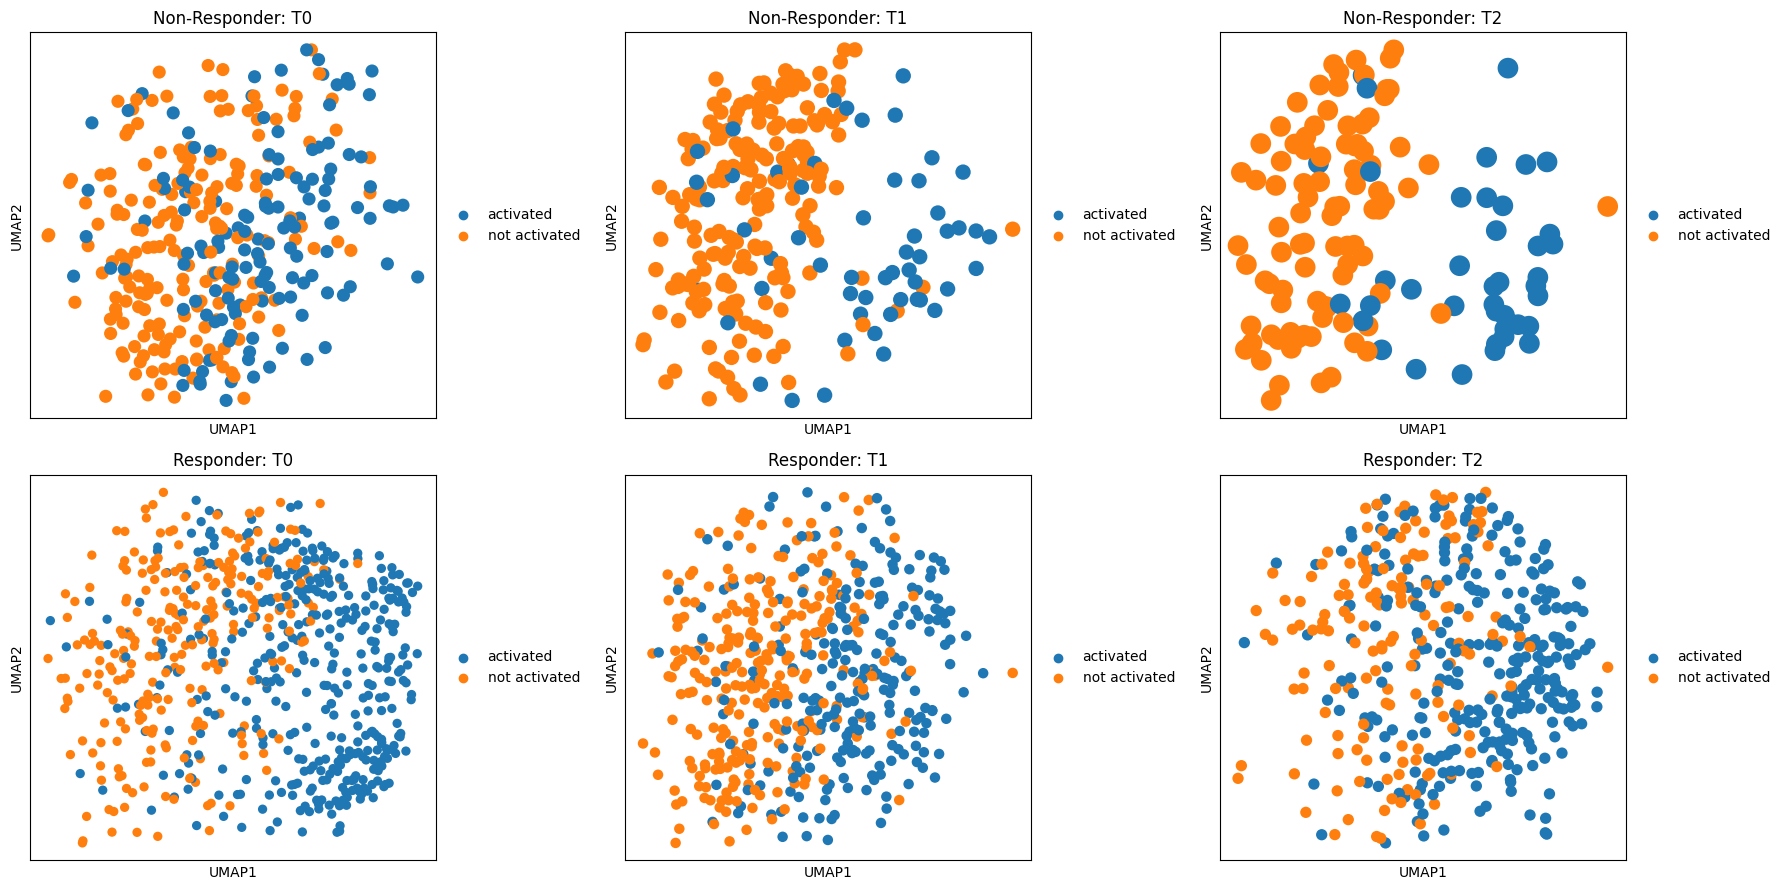

In [ ]:
import matplotlib.pyplot as plt
import scanpy as sc

responder_cells = mait_adata[mait_adata.obs['response'] == 'R']
non_responder_cells = mait_adata[mait_adata.obs['response'] == 'NR']

responder_T0 = responder_cells[responder_cells.obs['subject'] == 'T0']
responder_T1 = responder_cells[responder_cells.obs['subject'] == 'T1']
responder_T2 = responder_cells[responder_cells.obs['subject'] == 'T2']

non_responder_T0 = non_responder_cells[non_responder_cells.obs['subject'] == 'T0']
non_responder_T1 = non_responder_cells[non_responder_cells.obs['subject'] == 'T1']
non_responder_T2 = non_responder_cells[non_responder_cells.obs['subject'] == 'T2']

fig, axes = plt.subplots(2, 3, figsize=(18, 9))

#  Non-Responder
sc.pl.umap(non_responder_T0, ax=axes[0, 0], color='activation_status', title='Non-Responder: T0', show=False)
sc.pl.umap(non_responder_T1, ax=axes[0, 1], color='activation_status', title='Non-Responder: T1', show=False)
sc.pl.umap(non_responder_T2, ax=axes[0, 2], color='activation_status', title='Non-Responder: T2', show=False)

#  Responder
sc.pl.umap(responder_T0, ax=axes[1, 0], color='activation_status', title='Responder: T0', show=False)
sc.pl.umap(responder_T1, ax=axes[1, 1], color='activation_status', title='Responder: T1', show=False)
sc.pl.umap(responder_T2, ax=axes[1, 2], color='activation_status', title='Responder: T2', show=False)

plt.tight_layout()
plt.show()

Above figures show that MAIT cells are more abundant in responders. The outcome match to what the paper described.


## Proportion of activated MAIT cells between R and NR at T0, T1, T2
Then we calcuated the proportion of activated MAIT cells between Responder and Non-Responder at different timepoint.
The bar chart shows R showed higher proportion of activated MAIT compared to NR not only before therapy, but also after the first and the second cycle

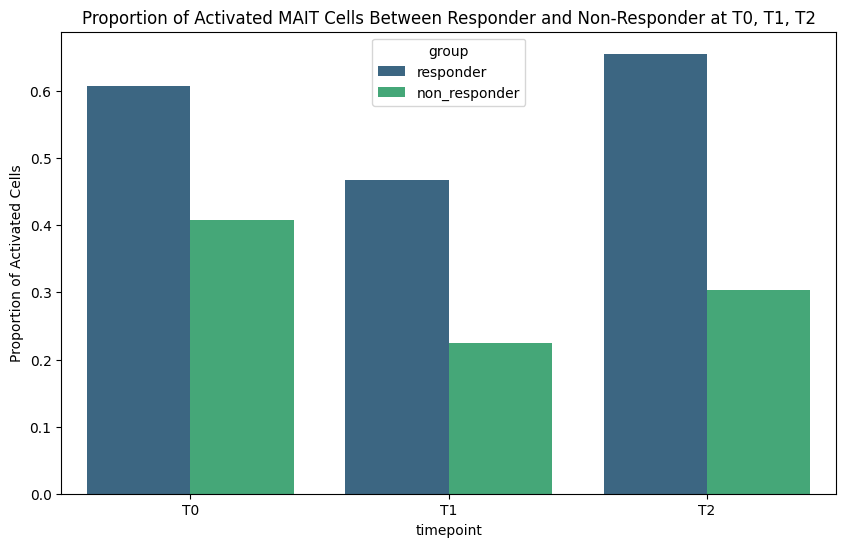

In [ ]:

def calculate_activated_ratio(cells_data):
    activated = cells_data.obs['activation_status'].value_counts(normalize=True).get('activated', 0)
    return activated


activated_ratios = {
    'responder_T0': calculate_activated_ratio(responder_T0),
    'responder_T1': calculate_activated_ratio(responder_T1),
    'responder_T2': calculate_activated_ratio(responder_T2),
    'non_responder_T0': calculate_activated_ratio(non_responder_T0),
    'non_responder_T1': calculate_activated_ratio(non_responder_T1),
    'non_responder_T2': calculate_activated_ratio(non_responder_T2),
}

data_barchart = {
    'timepoint': ['T0', 'T1', 'T2', 'T0', 'T1', 'T2'],
    'group': ['responder'] * 3 + ['non_responder'] * 3,
    'activated_ratio': [activated_ratios['responder_T0'], activated_ratios['responder_T1'], activated_ratios['responder_T2'],
                        activated_ratios['non_responder_T0'], activated_ratios['non_responder_T1'], activated_ratios['non_responder_T2']]
}

df = pd.DataFrame(data_barchart)

# bar char
plt.figure(figsize=(10, 6))
sns.barplot(x='timepoint', y='activated_ratio', hue='group', data=df, palette='viridis')

plt.title('Proportion of Activated MAIT Cells Between Responder and Non-Responder at T0, T1, T2')
plt.ylabel('Proportion of Activated Cells')
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
#DEA
sc.tl.rank_genes_groups(responder_cells, groupby='time', method='t-test', n_genes=100)
result_re = responder_cells.uns['rank_genes_groups']
markers_re = pd.DataFrame(result_re['names'])
sc.tl.rank_genes_groups(non_responder_cells, groupby='time', method='t-test', n_genes=100)
result_nore = non_responder_cells.uns['rank_genes_groups']
markers_nore = pd.DataFrame(result_nore['names'])
# TOP10
# print(markers_re.head(10))
# print(markers_nore.head(10))

In [ ]:
!pip install scvelo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 34.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.1/210.1 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.6/40.6 kB 1.8 MB/s eta 0:00:00
  Created wheel for loompy: filename=loompy-3.0.7-py3-none-any.whl size=52018 sha256=d53c6d994a695700d59216f432e8f97a97611ee26e9fef1bfb0da18a152fa828
  Stored in directory: /root/.cache/pip/wheels/2c/22/1f/792a4621bb631e538bf1c21feae9bbaa6b19fd6d6ab382d1fd
Successfully built loompy


## Trajectory analysis for MAIT cells

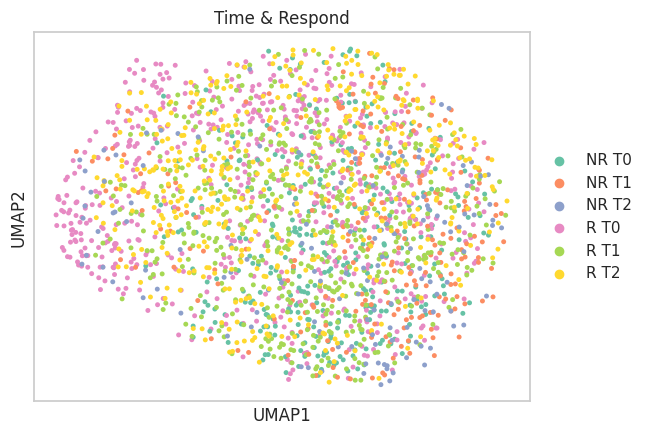

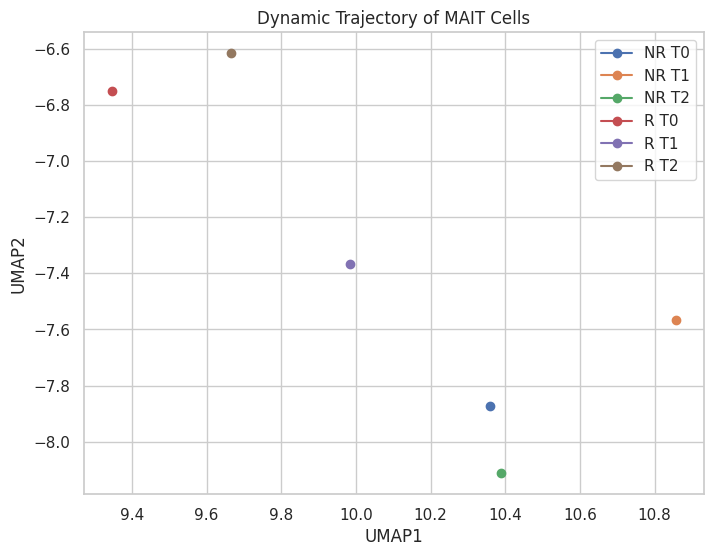

In [ ]:
#print(mait_adata)
sc.pp.neighbors(mait_adata, n_neighbors=15)
sc.tl.umap(mait_adata)

#mean center of dynamic trajectory
mait_adata.obs['UMAP1'] = mait_adata.obsm['X_umap'][:, 0]
mait_adata.obs['UMAP2'] = mait_adata.obsm['X_umap'][:, 1]

import seaborn as sns

custom_colors = sns.color_palette("Set2", n_colors=6)
mait_adata.uns['time_colors'] = custom_colors
sc.pl.umap(mait_adata, color=['time'], title=['Time & Respond'], wspace=0.5)

trajectory_means = mait_adata.obs.groupby(['time'])[['UMAP1', 'UMAP2']].mean().reset_index()

plt.figure(figsize=(8, 6))
for group in trajectory_means['time'].unique():
    group_data = trajectory_means[trajectory_means['time'] == group]
    plt.plot(group_data['UMAP1'], group_data['UMAP2'], marker='o', label=group)
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.legend()
plt.title('Dynamic Trajectory of MAIT Cells')
plt.show()

# Machine Learning Model for Respond Status(binary classification)

## merged Meta and Normalized Matrix

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import pandas as pd

metadata = pd.read_csv(DATA/"GSE166181_Metadata.tsv", sep='\t',header=0)
expression_matrix = pd.read_csv(DATA/"GSE166181_Normalized_UMI_CountMatrix.tsv", sep='\t',header=0).transpose()

metadata = metadata.reset_index(drop=True)
expression_matrix = expression_matrix.reset_index(drop=True)

                               cell_ID  time subject response  sample  WASH7P  \
0  R T0-Mela10 rep2_aaagaatgaattaaagaa  R T0      T0        R  Mela10     0.0   
1  R T0-Mela10 rep2_gcttgtgatcaacataga  R T0      T0        R  Mela10     0.0   
2  R T0-Mela10 rep2_gggatcccacgccttgaa  R T0      T0        R  Mela10     0.0   
3  R T0-Mela10 rep2_gggatctgctaattcttg  R T0      T0        R  Mela10     0.0   
4  R T0-Mela10 rep2_cggcgtgagtgatttggg  R T0      T0        R  Mela10     0.0   

   LOC729737  LOC100133331  LOC100288069  FAM87B  ...  BCYRN1  PCDH19  SYTL4  \
0        0.0           0.0           0.0     0.0  ...     0.0     0.0    0.0   
1        0.0           0.0           0.0     0.0  ...     0.0     0.0    0.0   
2        0.0           0.0           0.0     0.0  ...     0.0     0.0    0.0   
3        0.0           0.0           0.0     0.0  ...     0.0     0.0    0.0   
4        0.0           0.0           0.0     0.0  ...     0.0     0.0    0.0   

   HNRNPH2  TCEAL5  ESX1  TRPC5O

In [ ]:
merged_data = pd.concat([metadata, expression_matrix], axis=1)
columns_to_drop = ['orig.ident', 'nCount_RNA', 'nFeature_RNA', 'GeneReadCount', 'rRNAReads', 'pct.mito', 'pct.rRNA', 'pct.sncRNA','replicate']
merged_data = merged_data.drop(columns=columns_to_drop)

print(merged_data.head())
print(f"Merged data shape: {merged_data.shape}")
output_path = DATA/ "merged_data.csv"
merged_data.to_csv(output_path, index=False)
#saved as csv

                               cell_ID  time subject response  sample  WASH7P  \
0  R T0-Mela10 rep2_aaagaatgaattaaagaa  R T0      T0        R  Mela10     0.0   
1  R T0-Mela10 rep2_gcttgtgatcaacataga  R T0      T0        R  Mela10     0.0   
2  R T0-Mela10 rep2_gggatcccacgccttgaa  R T0      T0        R  Mela10     0.0   
3  R T0-Mela10 rep2_gggatctgctaattcttg  R T0      T0        R  Mela10     0.0   
4  R T0-Mela10 rep2_cggcgtgagtgatttggg  R T0      T0        R  Mela10     0.0   

   LOC729737  LOC100133331  LOC100288069  FAM87B  ...  PCDH19  SYTL4  HNRNPH2  \
0        0.0           0.0           0.0     0.0  ...     0.0    0.0      0.0   
1        0.0           0.0           0.0     0.0  ...     0.0    0.0      0.0   
2        0.0           0.0           0.0     0.0  ...     0.0    0.0      0.0   
3        0.0           0.0           0.0     0.0  ...     0.0    0.0      0.0   
4        0.0           0.0           0.0     0.0  ...     0.0    0.0      0.0   

   TCEAL5  ESX1  TRPC5OS  

## get gene name of cluster MAIT and extract MAIT-related gene dataset

In [ ]:
gene_names = mait_adata.var_names.tolist()
#print(gene_names[:10])

In [ ]:
matched_columns = [col for col in merged_data.columns if col in gene_names]
mait_4_ml = merged_data[[ 'cell_ID',  'time', 'subject', 'response' , 'sample'] + matched_columns]
#print(mait_4_ml.head())
mait_4_ml.to_csv(DATA/'mait_ml.csv', index=False)

In [ ]:
!pip install xgboost
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.0/199.0 MB 5.0 MB/s eta 0:00:00


### data preparation

In [ ]:
mait_4_ml = pd.read_csv(DATA/'mait_ml.csv')
merged_data= pd.read_csv(DATA/'merged_data.csv')

In [ ]:
features = mait_4_ml.loc[:, 'LOC729737':]
features_all = merged_data.loc[:, 'LOC729737':]
labels = merged_data['response'].map({'R': 1, 'NR': 0})
X_train, X_test, y_train, y_test = train_test_split(features_all, labels, test_size=0.3, random_state=100)

## XGBoost

### unweighted model

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [04:15:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy (unweighted): 0.72819289536458
Classification Report (unweighted):
               precision    recall  f1-score   support

           0       0.72      0.71      0.72      7485
           1       0.73      0.75      0.74      8026

    accuracy                           0.73     15511
   macro avg       0.73      0.73      0.73     15511
weighted avg       0.73      0.73      0.73     15511



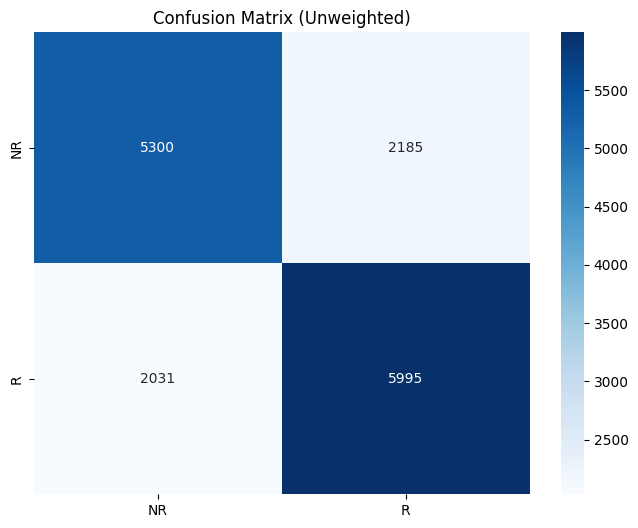

In [ ]:
# --------- 1. unweighted ---------
X = features_all  #
labels = merged_data['response'].map({'R': 1, 'NR': 0})

# split
X_train, X_test, y_train, y_test = train_test_split(X, labels , test_size=0.3, random_state=100)

# train
xgb_model_unweighted = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model_unweighted.fit(X_train, y_train)

# pre
y_pred_unweighted = xgb_model_unweighted.predict(X_test)
accuracy_unweighted = accuracy_score(y_test, y_pred_unweighted)
print(f"Accuracy (unweighted): {accuracy_unweighted}")
print("Classification Report (unweighted):\n", classification_report(y_test, y_pred_unweighted))

# Confusion Matrix
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, y_pred_unweighted), annot=True, fmt='d', cmap="Blues", xticklabels=["NR", "R"], yticklabels=["NR", "R"])
plt.title("Confusion Matrix (Unweighted)")
plt.show()


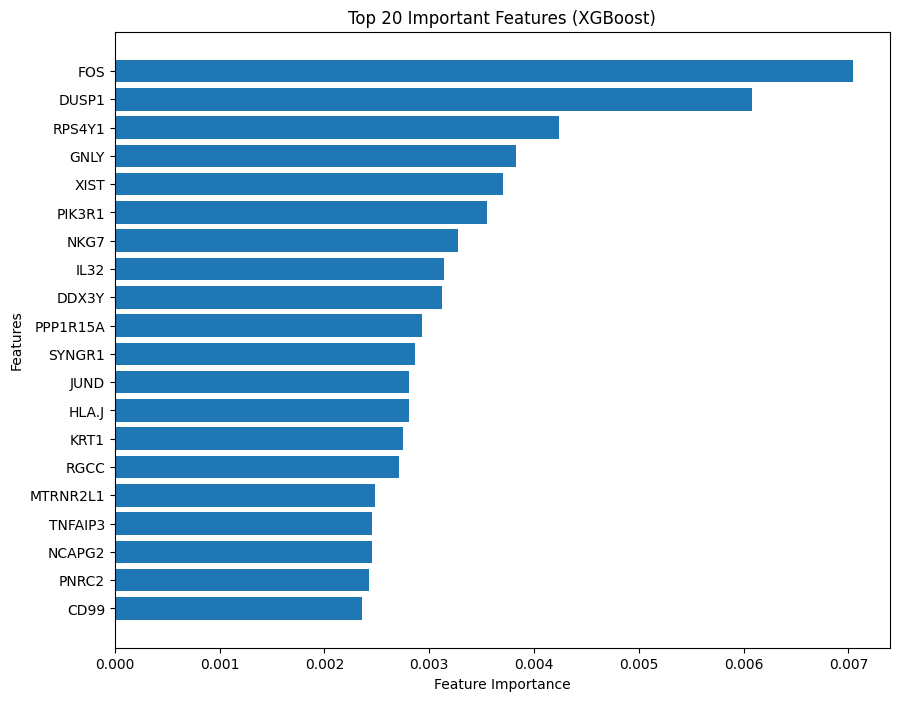

In [ ]:

feature_importance_xgb = pd.DataFrame({
    "Feature": X.columns,
    "Importance": xgb_model_unweighted.feature_importances_
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 8))
plt.barh(feature_importance_xgb["Feature"][:20], feature_importance_xgb["Importance"][:20])
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Top 20 Important Features (XGBoost)")
plt.gca().invert_yaxis()
plt.show()

### weighted model

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:51:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy (weighted): 0.5077042099155438
Classification Report (weighted):
               precision    recall  f1-score   support

           0       0.48      0.41      0.44      7400
           1       0.53      0.60      0.56      8111

    accuracy                           0.51     15511
   macro avg       0.50      0.50      0.50     15511
weighted avg       0.50      0.51      0.50     15511



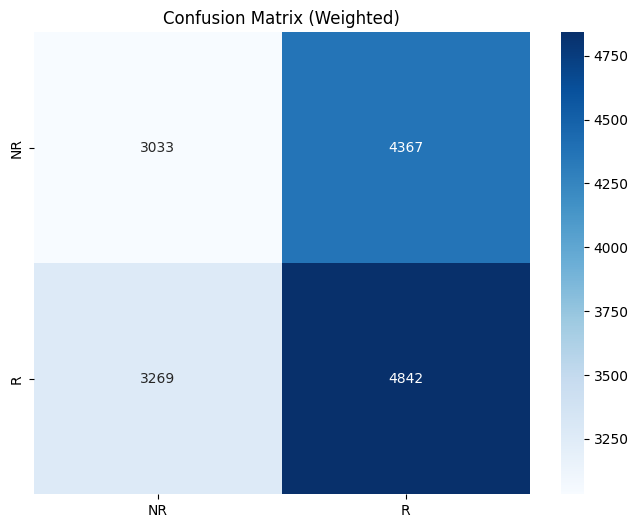

Accuracy Difference: -0.22048868544903621


In [ ]:

# --------- 2. weighted ---------

mait_genes = features.columns
weight_factor_mait = 10000
weight_factor_other = 0.0001

features_weighted = features.copy()


for gene in mait_genes:
    if gene in features_weighted.columns:
        features_weighted[gene] *= weight_factor_mait
    else:
        features_weighted[gene] *= weight_factor_other

xgb_model_weighted = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model_weighted.fit(X_train, y_train)


y_pred_weighted = xgb_model_weighted.predict(X_test)
accuracy_weighted = accuracy_score(y_test, y_pred_weighted)
print(f"Accuracy (weighted): {accuracy_weighted}")
print("Classification Report (weighted):\n", classification_report(y_test, y_pred_weighted))


plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, y_pred_weighted), annot=True, fmt='d', cmap="Blues", xticklabels=["NR", "R"], yticklabels=["NR", "R"])
plt.title("Confusion Matrix (Weighted)")
plt.show()

# --------- 3. compare ---------
print(f"Accuracy Difference: {accuracy_weighted - accuracy_unweighted}")

## Random Forest

### unweighted Random Forest

Evaluation for Random Forest (Original Features)
              precision    recall  f1-score   support

           0       0.64      0.64      0.64      7400
           1       0.67      0.67      0.67      8111

    accuracy                           0.65     15511
   macro avg       0.65      0.65      0.65     15511
weighted avg       0.65      0.65      0.65     15511

ROC-AUC Score: 0.6522494726880745


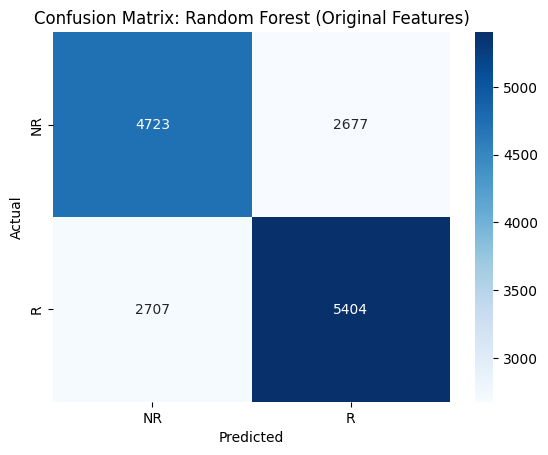

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

original_features = features_all
y = labels

X_train_orig, X_test_orig, y_train, y_test = train_test_split(
    original_features, y, test_size=0.3, random_state=100, stratify=y
)

rf_model_orig = RandomForestClassifier(random_state=100)
rf_model_weight = RandomForestClassifier(random_state=100)

rf_model_orig.fit(X_train_orig, y_train)
y_pred_orig = rf_model_orig.predict(X_test_orig)

def evaluate_model(y_test, y_pred, title):
    print(f"Evaluation for {title}")
    print(classification_report(y_test, y_pred))
    print(f"ROC-AUC Score: {roc_auc_score(pd.get_dummies(y_test), pd.get_dummies(y_pred))}")
    # confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["NR", "R"], yticklabels=["NR", "R"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix: {title}")
    plt.show()

evaluate_model(y_test, y_pred_orig, "Random Forest (Original Features)")


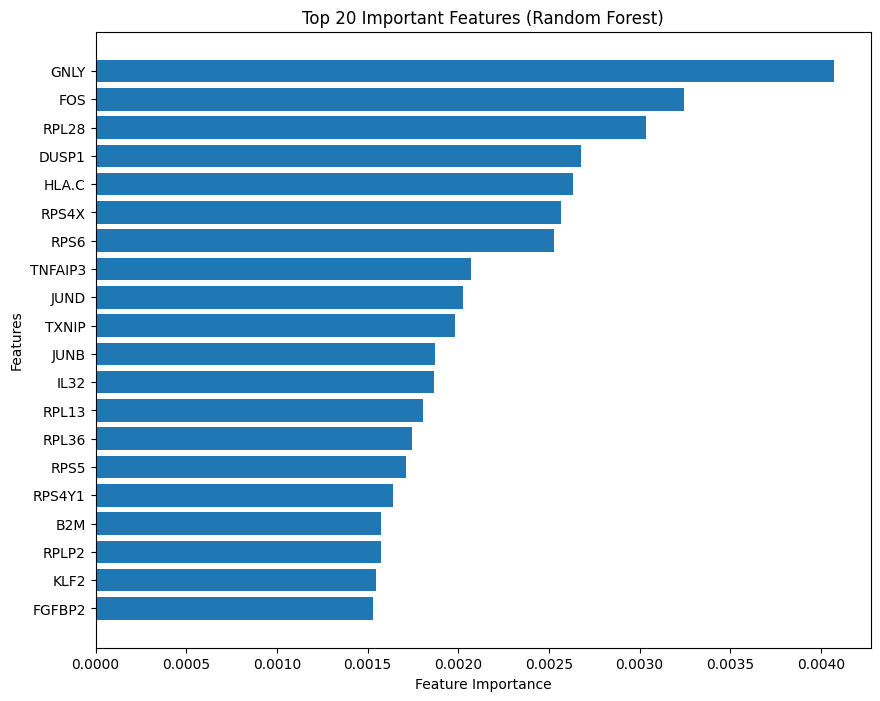

In [ ]:
feature_importance_rf = pd.DataFrame({
    "Feature": X.columns,
    "Importance": rf_model_orig.feature_importances_
}).sort_values(by="Importance", ascending=False)

# 绘制前20个重要特征
plt.figure(figsize=(10, 8))
plt.barh(feature_importance_rf["Feature"][:20], feature_importance_rf["Importance"][:20])
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Top 20 Important Features (Random Forest)")
plt.gca().invert_yaxis()
plt.show()

### weighted Random Forest

Evaluation for Random Forest (Weighted Features)
              precision    recall  f1-score   support

           0       0.64      0.64      0.64      7400
           1       0.67      0.67      0.67      8111

    accuracy                           0.65     15511
   macro avg       0.65      0.65      0.65     15511
weighted avg       0.65      0.65      0.65     15511

ROC-AUC Score: 0.6534325673842996


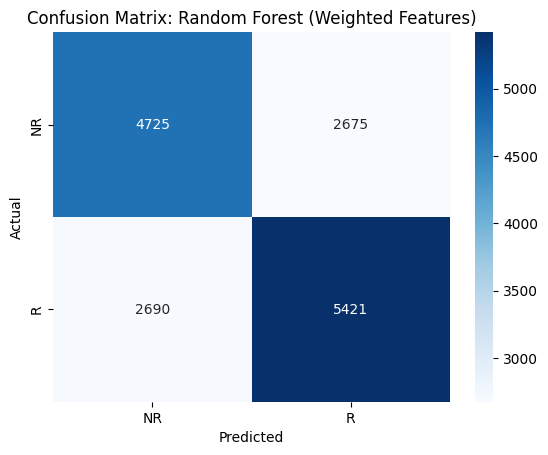

In [ ]:
mait_genes = features.columns
weighted_features = features_all.copy()
for gene in mait_genes:
    if gene in weighted_features.columns:
        weighted_features[gene] *= 10000

non_candidate_genes = [gene for gene in weighted_features.columns if gene not in mait_genes]
for gene in non_candidate_genes:
    weighted_features[gene] *= 0.0001

X_train_weight, X_test_weight, _, _ = train_test_split(
    weighted_features, y, test_size=0.3, random_state=100, stratify=y
)

rf_model_weight.fit(X_train_weight, y_train)
y_pred_weight = rf_model_weight.predict(X_test_weight)
evaluate_model(y_test, y_pred_weight, "Random Forest (Weighted Features)")

In [ ]:
top_rf_features = feature_importance_rf.head(50)['Feature'].tolist()
top_xgb_features = feature_importance_xgb.head(50)['Feature'].tolist()


common_rf_features = set(top_rf_features).intersection(set(mait_4_ml.columns))
common_xgb_features = set(top_xgb_features).intersection(set(mait_4_ml.columns))


importance_rf50_in_mait = mait_4_ml.columns.isin(common_rf_features).sum()
importance_xg50_in_mait = mait_4_ml.columns.isin(common_xgb_features).sum()

print(f"Number of common features in mait for RF: {importance_rf50_in_mait}")
print(f"feature:{common_rf_features}")
print(f"Number of common features in mait for XGBoost: {importance_xg50_in_mait}")
print(f"feature:{common_xgb_features}")

Number of common features in mait for RF: 10
feature:{'ARL4C', 'LTB', 'PIK3R1', 'JUND', 'FGFBP2', 'S100A4', 'DUSP1', 'TNFAIP3', 'FOS', 'JUNB'}
Number of common features in mait for XGBoost: 24
feature:{'RGCC', 'FCGR3A', 'FKBP5', 'JUND', 'NCAPG2', 'TNFAIP3', 'DDX3Y', 'ARL4C', 'RASA2', 'GBP1', 'PIK3R1', 'NKG7', 'DUSP1', 'FAM118A', 'PRKY', 'YPEL5', 'XIST', 'HLA.DRB1', 'FGFBP2', 'FMN1', 'FOS', 'ISG20', 'JUNB', 'GZMB'}
